# Importanción de librerías 

In [38]:
import tensorflow as tf
import sklearn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import librosa
import os

In [39]:
tf.test.is_gpu_available()

True

# Generación de ficheros

Esta función se encarga de generar un archivo txt de manera que este contenga 2 elementos por fila ('name_file','etiqueta') de esta manera permitirá poder entrenar la red.

In [40]:
import numpy as np
import os
def generate_file_data(dir,name):
    directory=dir
    #el nombre de los archivos posee el primer dígito en el nombre de esta forma permitirá etiquetarlos.
    a={'0':'cero','1':'uno','2':'dos','3':'tres','4':'cuatro','5':'cinco','6':'seis','7':'siete','8':'ocho','9':'nueve'}
    da=os.listdir(directory)
    # ordena los archivos
    da.sort()
    file = open(dir+name+'.txt',"w")
    for filename in da:
        if '.wav' in filename:
            file.write(filename+','+a[filename[0]]+'\n')
    file.close() 
    # genera el fichero
    with open(directory+'/'+name+'.txt') as f:
        read_data = f.read()
        f.closed
    read_data=read_data.split('\n')
    read_data=read_data[0:len(read_data)-1]
    return read_data

# Encoding words with One Hot Encoding
En esta sección se usará one hot encoding para representar las palabras

In [41]:
from sklearn.preprocessing import OneHotEncoder
vocabulary_words=np.array(['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve'])

In [42]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore',categories='auto')

In [43]:
onehot_encoder.fit(X=vocabulary_words.reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [44]:
onehot_encoder.categories_

[array(['cero', 'cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete',
        'tres', 'uno'], dtype='<U6')]

In [45]:
v=onehot_encoder.transform(vocabulary_words.reshape(-1,1)).toarray()

In [9]:
v

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [10]:
onehot_encoder.inverse_transform(v)

array([['cero'],
       ['uno'],
       ['dos'],
       ['tres'],
       ['cuatro'],
       ['cinco'],
       ['seis'],
       ['siete'],
       ['ocho'],
       ['nueve']], dtype='<U6')

### Se muestran las funciones para codificar y decodificar

In [46]:
def encode(x):# tomará un array de string y lo transformada a encode
    return onehot_encoder.transform(x.reshape(-1,1)).toarray()
def decode(x):
    return onehot_encoder.inverse_transform(x)

In [47]:
a=encode(np.array(['uno','dos']))

In [48]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [49]:
decode(a)

array([['uno'],
       ['dos']], dtype='<U6')

# MFCC 


In [65]:
def mfcc_features(DIR,list_dir,mean,delta):
    mfccd_audios=[]
    for dir in list_dir:
        wave, sr = librosa.load(DIR+dir, mono=True,sr=16000)
        features= librosa.feature.mfcc(wave, sr,n_mfcc=13)
        try:
            features=np.pad(features,((0,0),(0,110-len(features[0]))),mode='constant', constant_values=0)
        except OSError as err:
            print(dir)
        if delta == True:
            featuresdelta=librosa.feature.delta(features)
            features=np.concatenate((features, featuresdelta), axis=0)
        if mean == True:
            features=sklearn.preprocessing.scale(features,axis=0)
        mfccd_audios.append(features)
        
    mfccd_audios=np.array(mfccd_audios)
    return mfccd_audios

In [66]:
def prepare_data(dir,name,mean,delta):
    file = open(dir+name)
    f=file.read()
    file.close()
    f=f.split('\n')
    f=f[0:len(f)-1]
    labels=[]
    names_audios=[]
    for i in f:
        j=i.split(',')
        names_audios.append(j[0])
        labels.append(j[1])
    labels=np.array(labels)
    onehot= encode(labels)
    mfcc=mfcc_features(dir,names_audios,mean,delta)
    print(name+' OK')
    return mfcc,onehot



In [89]:
class dataset:
    def __init__(self,data):
        self.i=0#para el shuffle
        self.data_dir=data
        self.shuffle=None
        self.dir_training=data+'/training/'
        self.dir_test=data+'/test/'
        self.training_set=None
        self.test_set=None
    def split_dataset(self):
        if os.path.exists(self.dir_training+'training.txt')==False:
            generate_file_data(self.dir_training,name='training')
        if os.path.exists(self.dir_training+'test.txt')==False:
            generate_file_data(self.dir_test,name='test')
        print('loadfiles')
    def prepare(self,mean,delta):
        self.training_set=prepare_data(self.dir_training,'training.txt',mean,delta)
        self.test_set=prepare_data(self.dir_test,'test.txt',mean,delta)

    

In [90]:
d=dataset('data')
d.split_dataset()

loadfiles


In [91]:
d.prepare(mean=False,delta=True)

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


training.txt OK


/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


test.txt OK


# Red neuronal 

En esta sección se definen los distintos modelos a aplicar en este seminario

In [92]:
import sklearn
import tensorflow as tf
import time 
import matplotlib.pyplot as plt
import json
import os

In [93]:
# Se dividen los conjuntos
trainX, trainY = d.training_set[0],d.training_set[1]
testX, testY = d.test_set[0],d.test_set[1]
trainX=np.matrix.transpose(trainX,[0,2,1])
testX=np.matrix.transpose(testX,[0,2,1])

##### A continuación mostramos un elemento del training y test

In [94]:
trainX[0].shape

(110, 26)

In [86]:
trainX.shape

(240, 110, 26)

In [95]:
trainX[0]

array([[-5.47886929e+02,  2.10888556e+01,  1.00847706e+01, ...,
         1.03480394e+00, -6.07707637e-01,  3.06914671e-01],
       [-5.12919733e+02,  5.03670836e+01,  1.38455019e+01, ...,
         1.03480394e+00, -6.07707637e-01,  3.06914671e-01],
       [-4.99292312e+02,  6.13104118e+01,  1.39460105e+01, ...,
         1.03480394e+00, -6.07707637e-01,  3.06914671e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [96]:
testX[0]

array([[-5.15955778e+02,  4.53158084e-01,  4.40423351e-01, ...,
         4.62477042e-01,  9.55215444e-01,  4.75798914e-01],
       [-5.06970959e+02,  1.27755327e+01,  1.17358671e+01, ...,
         4.62477042e-01,  9.55215444e-01,  4.75798914e-01],
       [-4.96018059e+02,  2.62601550e+01,  2.04444784e+01, ...,
         4.62477042e-01,  9.55215444e-01,  4.75798914e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Modelos de prueba
A continuación presentamos 4 modelos que serán entrenados para el reconocimiento de voz.

In [83]:
def RNN_simple(name,n_units=128,time_steps=110,n_inputs=26,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(128, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [97]:
def LSTM_simple(name,n_units=128,time_steps=110,n_inputs=26,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [77]:
def LSTM_with_Dropout(name,n_units=128,time_steps=110,n_inputs=26,batch_size=10,n_epochs=400,dropout=0.5):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [78]:
def LSTM_with_2layers_1D(name,dropout,n_units=13,time_steps=110,n_inputs=26,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    #model.add(tf.keras.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

## Plotting and saving modelo
Se presentará una función que graficará los resultados y guardará el modelo y sus datos de entrenamiento

In [79]:
def plot_and_saving(history,name):
    dir='Models/Model_'
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Precision del Modelo')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/prec')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perdida del modelo')
    plt.ylabel('Perdida')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/cost')
    plt.show()
    json.dump(history.history, open('Models/Model_'+name+'/'+name+'_history', 'w'))


# Entrenamiento 
Entrenaremos distintas con los modelos definidos

In [88]:
RNN=RNN_simple('RNNsimple13mfcc')

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 3s 12ms/step - loss: 2.3765 - acc: 0.0750 - val_loss: 2.3898 - val_acc: 0.0727
Epoch 2/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3288 - acc: 0.1125 - val_loss: 2.3784 - val_acc: 0.1091
Epoch 3/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2957 - acc: 0.1167 - val_loss: 2.3595 - val_acc: 0.0909
Epoch 4/400
240/240 [==============================] - 2s 7ms/step - loss: 2.3173 - acc: 0.1542 - val_loss: 2.3558 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3212 - acc: 0.1083 - val_loss: 2.3335 - val_acc: 0.1000
Epoch 6/400
240/240 [==============================] - 2s 7ms/step - loss: 2.3099 - acc: 0.1083 - val_loss: 2.3148 - val_acc: 0.1273
Epoch 7/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2982 - acc: 0.1375 - val_loss: 2.3018 - val_acc: 0.1182
Epoch 8/400
240/240 [=

Epoch 62/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3009 - acc: 0.1083 - val_loss: 2.3175 - val_acc: 0.1182
Epoch 63/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2914 - acc: 0.1208 - val_loss: 2.3154 - val_acc: 0.1000
Epoch 64/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2996 - acc: 0.0958 - val_loss: 2.2779 - val_acc: 0.1545
Epoch 65/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2973 - acc: 0.1458 - val_loss: 2.3295 - val_acc: 0.1182
Epoch 66/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2960 - acc: 0.1458 - val_loss: 2.2825 - val_acc: 0.1545
Epoch 67/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3087 - acc: 0.1042 - val_loss: 2.3062 - val_acc: 0.1364
Epoch 68/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3005 - acc: 0.0875 - val_loss: 2.3212 - val_acc: 0.1182
Epoch 69/400
240/240 [==============================] - 1s 6ms

Epoch 123/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3028 - acc: 0.0667 - val_loss: 2.3251 - val_acc: 0.1182
Epoch 124/400
240/240 [==============================] - 1s 5ms/step - loss: 2.2815 - acc: 0.1208 - val_loss: 2.2971 - val_acc: 0.1182
Epoch 125/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2915 - acc: 0.1167 - val_loss: 2.3168 - val_acc: 0.1182
Epoch 126/400
240/240 [==============================] - 1s 5ms/step - loss: 2.2897 - acc: 0.1375 - val_loss: 2.3185 - val_acc: 0.1182
Epoch 127/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2923 - acc: 0.1292 - val_loss: 2.3032 - val_acc: 0.1182
Epoch 128/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2903 - acc: 0.1250 - val_loss: 2.2932 - val_acc: 0.1182
Epoch 129/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2909 - acc: 0.1083 - val_loss: 2.3147 - val_acc: 0.0818
Epoch 130/400
240/240 [==============================] 

Epoch 244/400
240/240 [==============================] - 1s 5ms/step - loss: 2.2885 - acc: 0.1042 - val_loss: 2.3159 - val_acc: 0.0818
Epoch 245/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2943 - acc: 0.1375 - val_loss: 2.3074 - val_acc: 0.1182
Epoch 246/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2991 - acc: 0.1000 - val_loss: 2.3008 - val_acc: 0.1182
Epoch 247/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2942 - acc: 0.1167 - val_loss: 2.2933 - val_acc: 0.1000
Epoch 248/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2787 - acc: 0.1083 - val_loss: 2.3076 - val_acc: 0.0818
Epoch 249/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2974 - acc: 0.1125 - val_loss: 2.3036 - val_acc: 0.1182
Epoch 250/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2873 - acc: 0.1208 - val_loss: 2.3048 - val_acc: 0.1182
Epoch 251/400
240/240 [==============================] 

Epoch 365/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3013 - acc: 0.0875 - val_loss: 2.2946 - val_acc: 0.1364
Epoch 366/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2894 - acc: 0.1167 - val_loss: 2.3067 - val_acc: 0.1545
Epoch 367/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2875 - acc: 0.0958 - val_loss: 2.2972 - val_acc: 0.1273
Epoch 368/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2909 - acc: 0.1417 - val_loss: 2.3169 - val_acc: 0.1182
Epoch 369/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2872 - acc: 0.1042 - val_loss: 2.3030 - val_acc: 0.1364
Epoch 370/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2994 - acc: 0.0958 - val_loss: 2.3154 - val_acc: 0.1000
Epoch 371/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2929 - acc: 0.0750 - val_loss: 2.3158 - val_acc: 0.1000
Epoch 372/400
240/240 [==============================] 

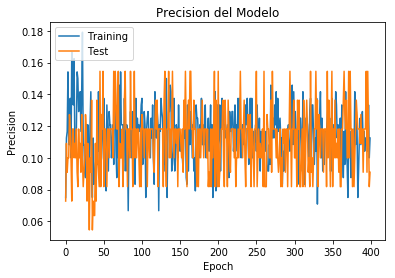

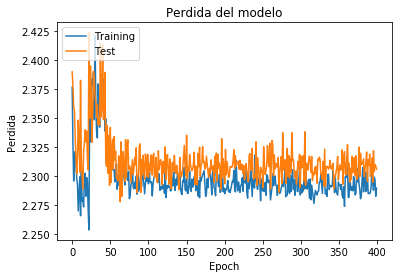

In [89]:
plot_and_saving(RNN,'RNNsimple13mfcc')

In [98]:
LSTM_SIMPLE=LSTM_simple(name='LSTM_13mfcc',n_units=256)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 6s 25ms/step - loss: 2.3104 - acc: 0.0833 - val_loss: 2.3051 - val_acc: 0.1000
Epoch 2/400
240/240 [==============================] - 5s 22ms/step - loss: 2.2944 - acc: 0.0958 - val_loss: 2.3132 - val_acc: 0.1091
Epoch 3/400
240/240 [==============================] - 7s 29ms/step - loss: 2.2995 - acc: 0.0958 - val_loss: 2.3033 - val_acc: 0.0909
Epoch 4/400
240/240 [==============================] - 5s 22ms/step - loss: 2.2871 - acc: 0.0958 - val_loss: 2.3021 - val_acc: 0.1091
Epoch 5/400
240/240 [==============================] - 6s 26ms/step - loss: 2.2788 - acc: 0.1250 - val_loss: 2.3047 - val_acc: 0.1000
Epoch 6/400
240/240 [==============================] - 6s 26ms/step - loss: 2.2678 - acc: 0.1292 - val_loss: 2.3133 - val_acc: 0.1000
Epoch 7/400
240/240 [==============================] - 6s 24ms/step - loss: 2.2741 - acc: 0.1000 - val_loss: 2.3040 - val_acc: 0.1091
Epoch 8/400
240/

240/240 [==============================] - 5s 20ms/step - loss: 0.9098 - acc: 0.5542 - val_loss: 1.4248 - val_acc: 0.4727
Epoch 62/400
240/240 [==============================] - 5s 20ms/step - loss: 0.8988 - acc: 0.6250 - val_loss: 1.4151 - val_acc: 0.4909
Epoch 63/400
240/240 [==============================] - 5s 22ms/step - loss: 0.9597 - acc: 0.5333 - val_loss: 1.3436 - val_acc: 0.4727
Epoch 64/400
240/240 [==============================] - 5s 22ms/step - loss: 0.9382 - acc: 0.5833 - val_loss: 1.3925 - val_acc: 0.5182
Epoch 65/400
240/240 [==============================] - 6s 27ms/step - loss: 1.0308 - acc: 0.5292 - val_loss: 1.2823 - val_acc: 0.5091
Epoch 66/400
240/240 [==============================] - 6s 23ms/step - loss: 0.9431 - acc: 0.6292 - val_loss: 1.1995 - val_acc: 0.4818
Epoch 67/400
240/240 [==============================] - 6s 24ms/step - loss: 0.9562 - acc: 0.5917 - val_loss: 1.2215 - val_acc: 0.5182
Epoch 68/400
240/240 [==============================] - 5s 23ms/step

240/240 [==============================] - 5s 21ms/step - loss: 0.5520 - acc: 0.8292 - val_loss: 0.9863 - val_acc: 0.7000
Epoch 122/400
240/240 [==============================] - 5s 22ms/step - loss: 0.4559 - acc: 0.8500 - val_loss: 1.1179 - val_acc: 0.6818
Epoch 123/400
240/240 [==============================] - 6s 25ms/step - loss: 0.4118 - acc: 0.8542 - val_loss: 1.0779 - val_acc: 0.7091
Epoch 124/400
240/240 [==============================] - 8s 32ms/step - loss: 0.2819 - acc: 0.8917 - val_loss: 1.0134 - val_acc: 0.7545
Epoch 125/400
240/240 [==============================] - 8s 34ms/step - loss: 0.2467 - acc: 0.9125 - val_loss: 1.0774 - val_acc: 0.7182
Epoch 126/400
240/240 [==============================] - 7s 30ms/step - loss: 0.2080 - acc: 0.9083 - val_loss: 1.0730 - val_acc: 0.6818
Epoch 127/400
240/240 [==============================] - 8s 31ms/step - loss: 0.1816 - acc: 0.9333 - val_loss: 1.0648 - val_acc: 0.7273
Epoch 128/400
240/240 [==============================] - 8s 31

240/240 [==============================] - 5s 22ms/step - loss: 0.0673 - acc: 0.9708 - val_loss: 0.8174 - val_acc: 0.8091
Epoch 182/400
240/240 [==============================] - 5s 22ms/step - loss: 0.0561 - acc: 0.9833 - val_loss: 0.8482 - val_acc: 0.8182
Epoch 183/400
240/240 [==============================] - 5s 21ms/step - loss: 0.0512 - acc: 0.9792 - val_loss: 0.8430 - val_acc: 0.8091
Epoch 184/400
240/240 [==============================] - 7s 28ms/step - loss: 0.0495 - acc: 0.9875 - val_loss: 0.8212 - val_acc: 0.8091
Epoch 185/400
240/240 [==============================] - 7s 28ms/step - loss: 0.0456 - acc: 0.9833 - val_loss: 0.8107 - val_acc: 0.8182
Epoch 186/400
240/240 [==============================] - 5s 22ms/step - loss: 0.0408 - acc: 0.9875 - val_loss: 0.8518 - val_acc: 0.8182
Epoch 187/400
240/240 [==============================] - 5s 21ms/step - loss: 0.0374 - acc: 0.9875 - val_loss: 0.8387 - val_acc: 0.8182
Epoch 188/400
240/240 [==============================] - 5s 21

KeyboardInterrupt: 

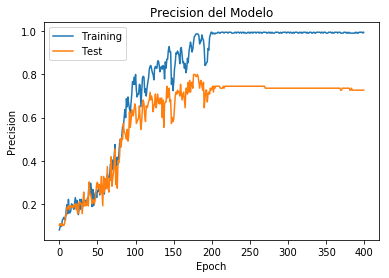

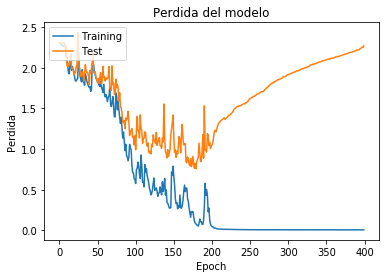

In [91]:
plot_and_saving(LSTM_SIMPLE,name='LSTM_13mfcc')

In [99]:
LSTMD5=LSTM_with_Dropout('LSTM_Dropout5_mfcc13',dropout=0.5)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 6s 26ms/step - loss: 2.3085 - acc: 0.0792 - val_loss: 2.3031 - val_acc: 0.1091
Epoch 2/400
240/240 [==============================] - 6s 24ms/step - loss: 2.2958 - acc: 0.1042 - val_loss: 2.3037 - val_acc: 0.1091
Epoch 3/400
240/240 [==============================] - 7s 29ms/step - loss: 2.2870 - acc: 0.0875 - val_loss: 2.3148 - val_acc: 0.0818
Epoch 4/400
240/240 [==============================] - 4s 19ms/step - loss: 2.2831 - acc: 0.1250 - val_loss: 2.3041 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 5s 22ms/step - loss: 2.2804 - acc: 0.1083 - val_loss: 2.3047 - val_acc: 0.1091
Epoch 6/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2804 - acc: 0.1167 - val_loss: 2.3043 - val_acc: 0.1091
Epoch 7/400
240/240 [==============================] - 5s 21ms/step - loss: 2.2654 - acc: 0.1125 - val_loss: 2.3220 - val_acc: 0.1000
Epoch 8/400
240/

240/240 [==============================] - 7s 29ms/step - loss: 1.5111 - acc: 0.3583 - val_loss: 1.8683 - val_acc: 0.2727
Epoch 62/400
240/240 [==============================] - 6s 26ms/step - loss: 1.4828 - acc: 0.3208 - val_loss: 1.8024 - val_acc: 0.3091
Epoch 63/400
240/240 [==============================] - 6s 23ms/step - loss: 1.4483 - acc: 0.4000 - val_loss: 1.9234 - val_acc: 0.3182
Epoch 64/400
240/240 [==============================] - 5s 21ms/step - loss: 1.3759 - acc: 0.3708 - val_loss: 1.7917 - val_acc: 0.2636
Epoch 65/400
240/240 [==============================] - 4s 18ms/step - loss: 1.3577 - acc: 0.3792 - val_loss: 1.8958 - val_acc: 0.3182
Epoch 66/400
240/240 [==============================] - 4s 17ms/step - loss: 1.4503 - acc: 0.3542 - val_loss: 2.0656 - val_acc: 0.2091
Epoch 67/400
240/240 [==============================] - 4s 18ms/step - loss: 1.6192 - acc: 0.3292 - val_loss: 1.8071 - val_acc: 0.2727
Epoch 68/400
240/240 [==============================] - 5s 21ms/step

240/240 [==============================] - 4s 19ms/step - loss: 1.0094 - acc: 0.5542 - val_loss: 2.2260 - val_acc: 0.3545
Epoch 122/400
240/240 [==============================] - 4s 18ms/step - loss: 1.0340 - acc: 0.5708 - val_loss: 2.0178 - val_acc: 0.3364
Epoch 123/400
240/240 [==============================] - 4s 17ms/step - loss: 0.9084 - acc: 0.5875 - val_loss: 2.0943 - val_acc: 0.3818
Epoch 124/400
240/240 [==============================] - 6s 26ms/step - loss: 0.9213 - acc: 0.5917 - val_loss: 2.1320 - val_acc: 0.3909
Epoch 125/400
240/240 [==============================] - 6s 25ms/step - loss: 0.8318 - acc: 0.6458 - val_loss: 2.1082 - val_acc: 0.3818
Epoch 126/400
240/240 [==============================] - 6s 25ms/step - loss: 0.8833 - acc: 0.6042 - val_loss: 2.0334 - val_acc: 0.3909
Epoch 127/400
240/240 [==============================] - 6s 25ms/step - loss: 1.0343 - acc: 0.5667 - val_loss: 2.4449 - val_acc: 0.3545
Epoch 128/400
240/240 [==============================] - 5s 20

240/240 [==============================] - 4s 17ms/step - loss: 1.0274 - acc: 0.6208 - val_loss: 2.3259 - val_acc: 0.3636
Epoch 182/400
240/240 [==============================] - 4s 18ms/step - loss: 0.7814 - acc: 0.6542 - val_loss: 1.9906 - val_acc: 0.4182
Epoch 183/400
240/240 [==============================] - 4s 17ms/step - loss: 0.8995 - acc: 0.6542 - val_loss: 2.6358 - val_acc: 0.3545
Epoch 184/400
240/240 [==============================] - 5s 19ms/step - loss: 0.7486 - acc: 0.6792 - val_loss: 1.9572 - val_acc: 0.4091
Epoch 185/400
240/240 [==============================] - 4s 19ms/step - loss: 0.6983 - acc: 0.7083 - val_loss: 2.2817 - val_acc: 0.3364
Epoch 186/400
240/240 [==============================] - 5s 20ms/step - loss: 1.2221 - acc: 0.5792 - val_loss: 2.1244 - val_acc: 0.3727
Epoch 187/400
240/240 [==============================] - 5s 19ms/step - loss: 0.9055 - acc: 0.6458 - val_loss: 2.5642 - val_acc: 0.3273
Epoch 188/400
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.2965 - acc: 0.8875 - val_loss: 2.4643 - val_acc: 0.5273
Epoch 242/400
240/240 [==============================] - 4s 17ms/step - loss: 0.6111 - acc: 0.8167 - val_loss: 2.1184 - val_acc: 0.5182
Epoch 243/400
240/240 [==============================] - 4s 18ms/step - loss: 0.5037 - acc: 0.8375 - val_loss: 1.9626 - val_acc: 0.4909
Epoch 244/400
240/240 [==============================] - 7s 28ms/step - loss: 0.6158 - acc: 0.8125 - val_loss: 2.2711 - val_acc: 0.4727
Epoch 245/400
240/240 [==============================] - 6s 25ms/step - loss: 0.2813 - acc: 0.9000 - val_loss: 1.8006 - val_acc: 0.5455
Epoch 246/400
240/240 [==============================] - 6s 25ms/step - loss: 0.1995 - acc: 0.9417 - val_loss: 1.9922 - val_acc: 0.5182
Epoch 247/400
240/240 [==============================] - 6s 26ms/step - loss: 0.2852 - acc: 0.9000 - val_loss: 1.9892 - val_acc: 0.5182
Epoch 248/400
240/240 [==============================] - 6s 25

240/240 [==============================] - 4s 15ms/step - loss: 0.3968 - acc: 0.8875 - val_loss: 1.7672 - val_acc: 0.5636
Epoch 302/400
240/240 [==============================] - 4s 15ms/step - loss: 0.4639 - acc: 0.8667 - val_loss: 1.8664 - val_acc: 0.5364
Epoch 303/400
240/240 [==============================] - 4s 17ms/step - loss: 0.2892 - acc: 0.9125 - val_loss: 1.7014 - val_acc: 0.5545
Epoch 304/400
240/240 [==============================] - 4s 17ms/step - loss: 0.4546 - acc: 0.8833 - val_loss: 2.3013 - val_acc: 0.5182
Epoch 305/400
240/240 [==============================] - 4s 16ms/step - loss: 1.0860 - acc: 0.7083 - val_loss: 1.7490 - val_acc: 0.4818
Epoch 306/400
240/240 [==============================] - 4s 15ms/step - loss: 0.6066 - acc: 0.8083 - val_loss: 1.6012 - val_acc: 0.5455
Epoch 307/400
240/240 [==============================] - 4s 15ms/step - loss: 0.4646 - acc: 0.8417 - val_loss: 1.7340 - val_acc: 0.6273
Epoch 308/400
240/240 [==============================] - 4s 18

240/240 [==============================] - 4s 17ms/step - loss: 0.0138 - acc: 0.9917 - val_loss: 2.2650 - val_acc: 0.5727
Epoch 362/400
240/240 [==============================] - 4s 15ms/step - loss: 0.0132 - acc: 0.9958 - val_loss: 2.2819 - val_acc: 0.5636
Epoch 363/400
240/240 [==============================] - 4s 18ms/step - loss: 0.0139 - acc: 0.9958 - val_loss: 2.2888 - val_acc: 0.5727
Epoch 364/400
240/240 [==============================] - 4s 16ms/step - loss: 0.0134 - acc: 0.9917 - val_loss: 2.2986 - val_acc: 0.5727
Epoch 365/400
240/240 [==============================] - 6s 24ms/step - loss: 0.0131 - acc: 0.9958 - val_loss: 2.3156 - val_acc: 0.5727
Epoch 366/400
240/240 [==============================] - 4s 18ms/step - loss: 0.0123 - acc: 0.9958 - val_loss: 2.3163 - val_acc: 0.5727
Epoch 367/400
240/240 [==============================] - 4s 17ms/step - loss: 0.0128 - acc: 0.9958 - val_loss: 2.3307 - val_acc: 0.5727
Epoch 368/400
240/240 [==============================] - 4s 18

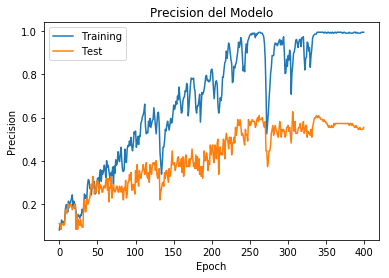

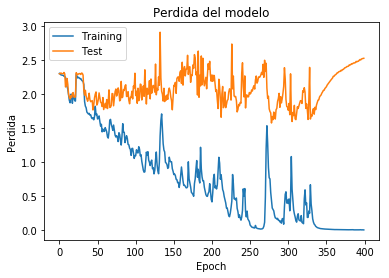

In [100]:
plot_and_saving(LSTMD5,name='LSTM_Dropout5_mfcc13')

In [101]:
LSTMD8=LSTM_with_Dropout('LSTM_Dropout8_mfcc13',dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 7s 28ms/step - loss: 2.3039 - acc: 0.0875 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/400
240/240 [==============================] - 5s 21ms/step - loss: 2.2886 - acc: 0.0958 - val_loss: 2.3043 - val_acc: 0.0909
Epoch 3/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2814 - acc: 0.1042 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/400
240/240 [==============================] - 5s 22ms/step - loss: 2.2688 - acc: 0.0958 - val_loss: 2.3086 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 5s 19ms/step - loss: 2.2694 - acc: 0.0958 - val_loss: 2.3071 - val_acc: 0.0909
Epoch 6/400
240/240 [==============================] - 4s 17ms/step - loss: 2.2799 - acc: 0.1208 - val_loss: 2.3097 - val_acc: 0.1000
Epoch 7/400
240/240 [==============================] - 4s 15ms/step - loss: 2.2804 - acc: 0.1167 - val_loss: 2.2995 - val_acc: 0.0818
Epoch 8/400
240/

240/240 [==============================] - 4s 17ms/step - loss: 2.0543 - acc: 0.2500 - val_loss: 3.0341 - val_acc: 0.1545
Epoch 62/400
240/240 [==============================] - 5s 21ms/step - loss: 2.5534 - acc: 0.1375 - val_loss: 2.3334 - val_acc: 0.0909
Epoch 63/400
240/240 [==============================] - 6s 25ms/step - loss: 2.2457 - acc: 0.1958 - val_loss: 2.1727 - val_acc: 0.1818
Epoch 64/400
240/240 [==============================] - 4s 18ms/step - loss: 2.1324 - acc: 0.1958 - val_loss: 2.1135 - val_acc: 0.1636
Epoch 65/400
240/240 [==============================] - 5s 20ms/step - loss: 2.0724 - acc: 0.1833 - val_loss: 1.9812 - val_acc: 0.2545
Epoch 66/400
240/240 [==============================] - 4s 16ms/step - loss: 2.0201 - acc: 0.1750 - val_loss: 1.9269 - val_acc: 0.1636
Epoch 67/400
240/240 [==============================] - 4s 17ms/step - loss: 1.8532 - acc: 0.1583 - val_loss: 1.9358 - val_acc: 0.2182
Epoch 68/400
240/240 [==============================] - 4s 17ms/step

240/240 [==============================] - 4s 18ms/step - loss: 1.5276 - acc: 0.2750 - val_loss: 1.6946 - val_acc: 0.2909
Epoch 122/400
240/240 [==============================] - 4s 17ms/step - loss: 1.5020 - acc: 0.3417 - val_loss: 1.7448 - val_acc: 0.3091
Epoch 123/400
240/240 [==============================] - 4s 17ms/step - loss: 1.4996 - acc: 0.3333 - val_loss: 1.8108 - val_acc: 0.2727
Epoch 124/400
240/240 [==============================] - 4s 18ms/step - loss: 1.5121 - acc: 0.3333 - val_loss: 1.7769 - val_acc: 0.2909
Epoch 125/400
240/240 [==============================] - 4s 18ms/step - loss: 1.4900 - acc: 0.3292 - val_loss: 1.6933 - val_acc: 0.3091
Epoch 126/400
240/240 [==============================] - 4s 16ms/step - loss: 1.4515 - acc: 0.4083 - val_loss: 1.7004 - val_acc: 0.3273
Epoch 127/400
240/240 [==============================] - 4s 16ms/step - loss: 1.4258 - acc: 0.4042 - val_loss: 1.7089 - val_acc: 0.3182
Epoch 128/400
240/240 [==============================] - 4s 16

240/240 [==============================] - 4s 18ms/step - loss: 1.0012 - acc: 0.5583 - val_loss: 1.5835 - val_acc: 0.4636
Epoch 182/400
240/240 [==============================] - 4s 18ms/step - loss: 0.8730 - acc: 0.6292 - val_loss: 1.6950 - val_acc: 0.4727
Epoch 183/400
240/240 [==============================] - 4s 17ms/step - loss: 0.8714 - acc: 0.6292 - val_loss: 1.6159 - val_acc: 0.4818
Epoch 184/400
240/240 [==============================] - 4s 18ms/step - loss: 0.8577 - acc: 0.6208 - val_loss: 1.6149 - val_acc: 0.4455
Epoch 185/400
240/240 [==============================] - 4s 18ms/step - loss: 0.8750 - acc: 0.6333 - val_loss: 1.8367 - val_acc: 0.4273
Epoch 186/400
240/240 [==============================] - 5s 20ms/step - loss: 1.3313 - acc: 0.4625 - val_loss: 1.5336 - val_acc: 0.4545
Epoch 187/400
240/240 [==============================] - 5s 22ms/step - loss: 1.3861 - acc: 0.4958 - val_loss: 1.8301 - val_acc: 0.4091
Epoch 188/400
240/240 [==============================] - 5s 23

240/240 [==============================] - 4s 17ms/step - loss: 0.9868 - acc: 0.5833 - val_loss: 1.3850 - val_acc: 0.4727
Epoch 242/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7905 - acc: 0.6917 - val_loss: 1.2853 - val_acc: 0.5091
Epoch 243/400
240/240 [==============================] - 4s 18ms/step - loss: 0.6834 - acc: 0.7417 - val_loss: 1.3421 - val_acc: 0.5182
Epoch 244/400
240/240 [==============================] - 6s 23ms/step - loss: 0.6466 - acc: 0.7333 - val_loss: 1.3103 - val_acc: 0.5091
Epoch 245/400
240/240 [==============================] - 4s 17ms/step - loss: 0.6814 - acc: 0.7417 - val_loss: 1.2968 - val_acc: 0.5273
Epoch 246/400
240/240 [==============================] - 9s 39ms/step - loss: 0.5930 - acc: 0.7458 - val_loss: 1.2825 - val_acc: 0.5455
Epoch 247/400
240/240 [==============================] - 6s 25ms/step - loss: 0.5589 - acc: 0.7917 - val_loss: 1.2323 - val_acc: 0.5455
Epoch 248/400
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 18ms/step - loss: 0.1686 - acc: 0.9167 - val_loss: 1.4902 - val_acc: 0.5909
Epoch 302/400
240/240 [==============================] - 4s 18ms/step - loss: 0.1633 - acc: 0.9208 - val_loss: 1.4775 - val_acc: 0.6091
Epoch 303/400
240/240 [==============================] - 4s 16ms/step - loss: 0.1518 - acc: 0.9333 - val_loss: 1.5189 - val_acc: 0.5818
Epoch 304/400
240/240 [==============================] - 4s 18ms/step - loss: 0.1691 - acc: 0.9083 - val_loss: 1.4753 - val_acc: 0.6091
Epoch 305/400
240/240 [==============================] - 4s 18ms/step - loss: 0.1770 - acc: 0.9250 - val_loss: 1.5789 - val_acc: 0.6091
Epoch 306/400
240/240 [==============================] - 4s 17ms/step - loss: 0.2169 - acc: 0.9083 - val_loss: 1.6790 - val_acc: 0.6000
Epoch 307/400
240/240 [==============================] - 4s 16ms/step - loss: 0.3412 - acc: 0.8625 - val_loss: 1.6240 - val_acc: 0.5818
Epoch 308/400
240/240 [==============================] - 4s 15

240/240 [==============================] - 6s 24ms/step - loss: 0.2077 - acc: 0.9292 - val_loss: 1.7202 - val_acc: 0.5818
Epoch 362/400
240/240 [==============================] - 5s 22ms/step - loss: 0.4549 - acc: 0.8250 - val_loss: 1.5555 - val_acc: 0.6364
Epoch 363/400
240/240 [==============================] - 5s 21ms/step - loss: 0.4713 - acc: 0.8417 - val_loss: 1.7498 - val_acc: 0.5273
Epoch 364/400
240/240 [==============================] - 4s 16ms/step - loss: 0.3525 - acc: 0.8542 - val_loss: 1.4403 - val_acc: 0.5818
Epoch 365/400
240/240 [==============================] - 4s 17ms/step - loss: 0.4207 - acc: 0.8542 - val_loss: 1.5617 - val_acc: 0.5727
Epoch 366/400
240/240 [==============================] - 4s 16ms/step - loss: 0.5607 - acc: 0.8125 - val_loss: 1.3497 - val_acc: 0.6273
Epoch 367/400
240/240 [==============================] - 4s 15ms/step - loss: 0.4971 - acc: 0.8292 - val_loss: 1.6720 - val_acc: 0.5909
Epoch 368/400
240/240 [==============================] - 4s 17

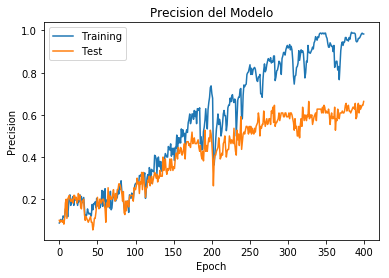

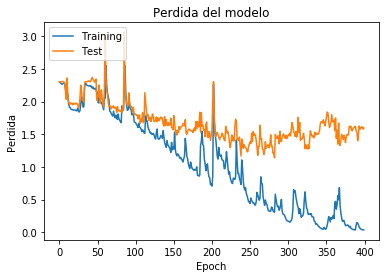

In [102]:
plot_and_saving(LSTMD8,name='LSTM_Dropout8_mfcc13')

In [103]:
LSTM2_1=LSTM_with_2layers_1D('LSTM_2Layer1DDelta8',dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 11s 47ms/step - loss: 2.3048 - acc: 0.0917 - val_loss: 2.3028 - val_acc: 0.0909
Epoch 2/400
240/240 [==============================] - 11s 45ms/step - loss: 2.3015 - acc: 0.0833 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 3/400
240/240 [==============================] - 14s 58ms/step - loss: 2.2945 - acc: 0.1083 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 4/400
240/240 [==============================] - 11s 45ms/step - loss: 2.2998 - acc: 0.1042 - val_loss: 2.3040 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 13s 56ms/step - loss: 2.3054 - acc: 0.1000 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 6/400
240/240 [==============================] - 9s 38ms/step - loss: 2.3072 - acc: 0.0917 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 7/400
240/240 [==============================] - 8s 34ms/step - loss: 2.2966 - acc: 0.1083 - val_loss: 2.3028 - val_acc: 0.0909
Epoch 8/400

240/240 [==============================] - 9s 36ms/step - loss: 2.1694 - acc: 0.1583 - val_loss: 2.0996 - val_acc: 0.1818
Epoch 62/400
240/240 [==============================] - 8s 33ms/step - loss: 2.0594 - acc: 0.1583 - val_loss: 2.0593 - val_acc: 0.1818
Epoch 63/400
240/240 [==============================] - 8s 33ms/step - loss: 2.0453 - acc: 0.2042 - val_loss: 2.0384 - val_acc: 0.2000
Epoch 64/400
240/240 [==============================] - 8s 32ms/step - loss: 2.0997 - acc: 0.1792 - val_loss: 2.0750 - val_acc: 0.1818
Epoch 65/400
240/240 [==============================] - 8s 35ms/step - loss: 2.1072 - acc: 0.1625 - val_loss: 2.0717 - val_acc: 0.2000
Epoch 66/400
240/240 [==============================] - 11s 46ms/step - loss: 2.0703 - acc: 0.1417 - val_loss: 2.0601 - val_acc: 0.1818
Epoch 67/400
240/240 [==============================] - 8s 33ms/step - loss: 2.0817 - acc: 0.1333 - val_loss: 2.0503 - val_acc: 0.1909
Epoch 68/400
240/240 [==============================] - 9s 36ms/ste

240/240 [==============================] - 8s 33ms/step - loss: 1.8588 - acc: 0.2333 - val_loss: 1.9253 - val_acc: 0.2182
Epoch 122/400
240/240 [==============================] - 8s 34ms/step - loss: 1.8082 - acc: 0.2708 - val_loss: 1.9114 - val_acc: 0.2545
Epoch 123/400
240/240 [==============================] - 8s 33ms/step - loss: 1.8441 - acc: 0.2000 - val_loss: 1.9962 - val_acc: 0.2091
Epoch 124/400
240/240 [==============================] - 8s 35ms/step - loss: 1.7788 - acc: 0.2667 - val_loss: 1.9803 - val_acc: 0.2364
Epoch 125/400
240/240 [==============================] - 9s 36ms/step - loss: 1.8745 - acc: 0.2333 - val_loss: 1.9278 - val_acc: 0.2273
Epoch 126/400
240/240 [==============================] - 9s 36ms/step - loss: 1.8295 - acc: 0.2292 - val_loss: 1.9264 - val_acc: 0.2455
Epoch 127/400
240/240 [==============================] - 8s 34ms/step - loss: 1.8301 - acc: 0.2292 - val_loss: 1.9387 - val_acc: 0.2545
Epoch 128/400
240/240 [==============================] - 8s 35

240/240 [==============================] - 10s 41ms/step - loss: 1.7797 - acc: 0.2542 - val_loss: 1.8862 - val_acc: 0.2727
Epoch 182/400
240/240 [==============================] - 9s 39ms/step - loss: 1.7380 - acc: 0.2417 - val_loss: 1.8688 - val_acc: 0.2818
Epoch 183/400
240/240 [==============================] - 9s 36ms/step - loss: 1.7003 - acc: 0.2958 - val_loss: 1.8593 - val_acc: 0.2727
Epoch 184/400
240/240 [==============================] - 8s 34ms/step - loss: 1.7438 - acc: 0.2500 - val_loss: 1.9047 - val_acc: 0.2545
Epoch 185/400
240/240 [==============================] - 9s 36ms/step - loss: 1.6830 - acc: 0.2750 - val_loss: 1.9096 - val_acc: 0.2727
Epoch 186/400
240/240 [==============================] - 9s 35ms/step - loss: 1.7637 - acc: 0.2333 - val_loss: 1.9144 - val_acc: 0.2364
Epoch 187/400
240/240 [==============================] - 9s 38ms/step - loss: 1.7052 - acc: 0.3250 - val_loss: 1.9239 - val_acc: 0.2636
Epoch 188/400
240/240 [==============================] - 8s 3

240/240 [==============================] - 8s 32ms/step - loss: 1.8704 - acc: 0.1958 - val_loss: 1.8911 - val_acc: 0.2364
Epoch 242/400
240/240 [==============================] - 8s 32ms/step - loss: 1.7401 - acc: 0.2625 - val_loss: 1.8595 - val_acc: 0.2818
Epoch 243/400
240/240 [==============================] - 8s 32ms/step - loss: 1.7675 - acc: 0.2417 - val_loss: 1.8892 - val_acc: 0.3091
Epoch 244/400
240/240 [==============================] - 8s 32ms/step - loss: 1.7412 - acc: 0.2375 - val_loss: 1.8859 - val_acc: 0.3455
Epoch 245/400
240/240 [==============================] - 8s 32ms/step - loss: 1.7598 - acc: 0.2667 - val_loss: 1.8808 - val_acc: 0.3455
Epoch 246/400
240/240 [==============================] - 8s 32ms/step - loss: 1.6395 - acc: 0.3042 - val_loss: 1.8185 - val_acc: 0.3091
Epoch 247/400
240/240 [==============================] - 8s 32ms/step - loss: 1.6740 - acc: 0.2583 - val_loss: 1.8331 - val_acc: 0.3182
Epoch 248/400
240/240 [==============================] - 8s 32

240/240 [==============================] - 9s 36ms/step - loss: 1.5798 - acc: 0.3125 - val_loss: 1.9482 - val_acc: 0.2455
Epoch 302/400
240/240 [==============================] - 9s 36ms/step - loss: 1.6533 - acc: 0.2750 - val_loss: 1.8779 - val_acc: 0.2909
Epoch 303/400
240/240 [==============================] - 9s 37ms/step - loss: 1.6603 - acc: 0.2958 - val_loss: 1.7967 - val_acc: 0.2909
Epoch 304/400
240/240 [==============================] - 9s 39ms/step - loss: 1.5822 - acc: 0.3458 - val_loss: 1.8860 - val_acc: 0.2909
Epoch 305/400
240/240 [==============================] - 9s 37ms/step - loss: 1.5078 - acc: 0.3458 - val_loss: 1.7969 - val_acc: 0.2909
Epoch 306/400
240/240 [==============================] - 9s 39ms/step - loss: 1.5446 - acc: 0.3125 - val_loss: 1.8782 - val_acc: 0.2364
Epoch 307/400
240/240 [==============================] - 8s 33ms/step - loss: 1.5219 - acc: 0.3292 - val_loss: 1.8299 - val_acc: 0.3091
Epoch 308/400
240/240 [==============================] - 8s 32

240/240 [==============================] - 10s 41ms/step - loss: 1.6255 - acc: 0.2667 - val_loss: 1.9216 - val_acc: 0.3636
Epoch 362/400
240/240 [==============================] - 9s 36ms/step - loss: 1.5097 - acc: 0.2917 - val_loss: 1.7797 - val_acc: 0.3091
Epoch 363/400
240/240 [==============================] - 9s 39ms/step - loss: 1.5624 - acc: 0.2792 - val_loss: 1.8986 - val_acc: 0.3273
Epoch 364/400
240/240 [==============================] - 8s 33ms/step - loss: 1.5629 - acc: 0.3167 - val_loss: 1.9040 - val_acc: 0.3091
Epoch 365/400
240/240 [==============================] - 9s 39ms/step - loss: 1.4703 - acc: 0.3333 - val_loss: 1.7410 - val_acc: 0.3182
Epoch 366/400
240/240 [==============================] - 8s 33ms/step - loss: 1.5562 - acc: 0.3500 - val_loss: 1.8249 - val_acc: 0.3273
Epoch 367/400
240/240 [==============================] - 8s 33ms/step - loss: 1.5139 - acc: 0.3167 - val_loss: 1.8574 - val_acc: 0.3364
Epoch 368/400
240/240 [==============================] - 11s 

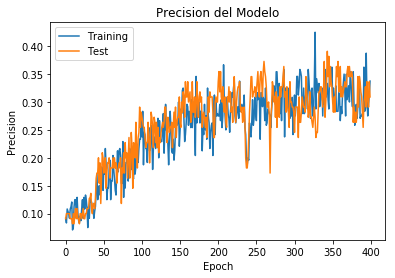

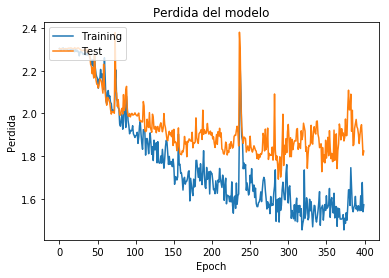

In [104]:
plot_and_saving(LSTM2_1,name='LSTM_2Layer1DDelta8')

In [105]:
LSTM2_1iter9005=LSTM_with_2layers_1D('LSTM_2Layer1D_13mfcc_Delta5iter900',dropout=0.5,n_epochs=900)

Train on 240 samples, validate on 110 samples
Epoch 1/900
240/240 [==============================] - 13s 53ms/step - loss: 2.3046 - acc: 0.0750 - val_loss: 2.3024 - val_acc: 0.1182
Epoch 2/900
240/240 [==============================] - 10s 40ms/step - loss: 2.3048 - acc: 0.0833 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 3/900
240/240 [==============================] - 11s 47ms/step - loss: 2.3032 - acc: 0.0875 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/900
240/240 [==============================] - 12s 48ms/step - loss: 2.3026 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/900
240/240 [==============================] - 9s 37ms/step - loss: 2.3040 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 6/900
240/240 [==============================] - 9s 37ms/step - loss: 2.3029 - acc: 0.1042 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/900
240/240 [==============================] - 9s 39ms/step - loss: 2.3016 - acc: 0.1083 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 8/900


240/240 [==============================] - 9s 37ms/step - loss: 2.2111 - acc: 0.1417 - val_loss: 2.3298 - val_acc: 0.0909
Epoch 62/900
240/240 [==============================] - 9s 39ms/step - loss: 2.1653 - acc: 0.1625 - val_loss: 2.3344 - val_acc: 0.0727
Epoch 63/900
240/240 [==============================] - 10s 40ms/step - loss: 2.1825 - acc: 0.1417 - val_loss: 2.3410 - val_acc: 0.0909
Epoch 64/900
240/240 [==============================] - 10s 44ms/step - loss: 2.1821 - acc: 0.1333 - val_loss: 2.3237 - val_acc: 0.0909
Epoch 65/900
240/240 [==============================] - 10s 42ms/step - loss: 2.1788 - acc: 0.1583 - val_loss: 2.3337 - val_acc: 0.0909
Epoch 66/900
240/240 [==============================] - 10s 43ms/step - loss: 2.1732 - acc: 0.1417 - val_loss: 2.3293 - val_acc: 0.1182
Epoch 67/900
240/240 [==============================] - 10s 43ms/step - loss: 2.1825 - acc: 0.1625 - val_loss: 2.3363 - val_acc: 0.1091
Epoch 68/900
240/240 [==============================] - 10s 41m

240/240 [==============================] - 8s 34ms/step - loss: 2.0664 - acc: 0.2208 - val_loss: 2.4073 - val_acc: 0.1273
Epoch 122/900
240/240 [==============================] - 8s 34ms/step - loss: 2.0495 - acc: 0.2458 - val_loss: 2.4444 - val_acc: 0.1000
Epoch 123/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0350 - acc: 0.2417 - val_loss: 2.4763 - val_acc: 0.1182
Epoch 124/900
240/240 [==============================] - 8s 34ms/step - loss: 2.0686 - acc: 0.2167 - val_loss: 2.4381 - val_acc: 0.1455
Epoch 125/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0344 - acc: 0.2500 - val_loss: 2.4124 - val_acc: 0.1182
Epoch 126/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0195 - acc: 0.2292 - val_loss: 2.4632 - val_acc: 0.1091
Epoch 127/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0692 - acc: 0.2292 - val_loss: 2.4093 - val_acc: 0.1000
Epoch 128/900
240/240 [==============================] - 9s 37

240/240 [==============================] - 9s 37ms/step - loss: 2.2346 - acc: 0.1625 - val_loss: 2.3062 - val_acc: 0.0727
Epoch 182/900
240/240 [==============================] - 9s 38ms/step - loss: 2.2396 - acc: 0.1458 - val_loss: 2.3163 - val_acc: 0.0727
Epoch 183/900
240/240 [==============================] - 10s 43ms/step - loss: 2.2440 - acc: 0.1583 - val_loss: 2.3126 - val_acc: 0.1000
Epoch 184/900
240/240 [==============================] - 10s 41ms/step - loss: 2.1966 - acc: 0.1667 - val_loss: 2.3203 - val_acc: 0.0818
Epoch 185/900
240/240 [==============================] - 9s 37ms/step - loss: 2.2051 - acc: 0.1625 - val_loss: 2.3367 - val_acc: 0.0909
Epoch 186/900
240/240 [==============================] - 14s 60ms/step - loss: 2.2060 - acc: 0.1708 - val_loss: 2.3148 - val_acc: 0.1091
Epoch 187/900
240/240 [==============================] - 9s 40ms/step - loss: 2.2289 - acc: 0.1625 - val_loss: 2.2982 - val_acc: 0.0909
Epoch 188/900
240/240 [==============================] - 9s

240/240 [==============================] - 8s 33ms/step - loss: 2.0489 - acc: 0.2250 - val_loss: 2.4223 - val_acc: 0.1545
Epoch 242/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0731 - acc: 0.2208 - val_loss: 2.4776 - val_acc: 0.1364
Epoch 243/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0654 - acc: 0.2083 - val_loss: 2.4882 - val_acc: 0.1455
Epoch 244/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0935 - acc: 0.2375 - val_loss: 2.5188 - val_acc: 0.1636
Epoch 245/900
240/240 [==============================] - 8s 33ms/step - loss: 2.1108 - acc: 0.2125 - val_loss: 2.5447 - val_acc: 0.1273
Epoch 246/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0477 - acc: 0.2042 - val_loss: 2.4360 - val_acc: 0.1182
Epoch 247/900
240/240 [==============================] - 8s 33ms/step - loss: 2.0242 - acc: 0.2250 - val_loss: 2.4521 - val_acc: 0.1364
Epoch 248/900
240/240 [==============================] - 8s 33

240/240 [==============================] - 11s 47ms/step - loss: 1.8329 - acc: 0.3583 - val_loss: 2.6941 - val_acc: 0.1455
Epoch 302/900
240/240 [==============================] - 10s 41ms/step - loss: 1.8690 - acc: 0.3042 - val_loss: 2.6987 - val_acc: 0.1727
Epoch 303/900
240/240 [==============================] - 10s 42ms/step - loss: 1.8577 - acc: 0.3125 - val_loss: 2.6766 - val_acc: 0.1818
Epoch 304/900
240/240 [==============================] - 10s 42ms/step - loss: 1.8689 - acc: 0.3083 - val_loss: 2.6661 - val_acc: 0.1455
Epoch 305/900
240/240 [==============================] - 10s 42ms/step - loss: 1.8848 - acc: 0.3083 - val_loss: 2.6909 - val_acc: 0.1818
Epoch 306/900
240/240 [==============================] - 10s 42ms/step - loss: 1.8548 - acc: 0.3458 - val_loss: 2.6055 - val_acc: 0.1455
Epoch 307/900
240/240 [==============================] - 10s 42ms/step - loss: 1.8623 - acc: 0.3292 - val_loss: 2.6486 - val_acc: 0.1636
Epoch 308/900
240/240 [==============================] 

240/240 [==============================] - 8s 33ms/step - loss: 1.9131 - acc: 0.3125 - val_loss: 2.8854 - val_acc: 0.0455
Epoch 362/900
240/240 [==============================] - 8s 32ms/step - loss: 1.9059 - acc: 0.2875 - val_loss: 2.9434 - val_acc: 0.0818
Epoch 363/900
240/240 [==============================] - 10s 43ms/step - loss: 1.8476 - acc: 0.3417 - val_loss: 2.8818 - val_acc: 0.0818
Epoch 364/900
240/240 [==============================] - 13s 55ms/step - loss: 1.8460 - acc: 0.3375 - val_loss: 2.7930 - val_acc: 0.1000
Epoch 365/900
240/240 [==============================] - 12s 51ms/step - loss: 1.8127 - acc: 0.3667 - val_loss: 2.8074 - val_acc: 0.1000
Epoch 366/900
240/240 [==============================] - 14s 59ms/step - loss: 1.7645 - acc: 0.3250 - val_loss: 2.7996 - val_acc: 0.1091
Epoch 367/900
240/240 [==============================] - 14s 57ms/step - loss: 1.8564 - acc: 0.2833 - val_loss: 2.8071 - val_acc: 0.1091
Epoch 368/900
240/240 [==============================] - 

Epoch 421/900
240/240 [==============================] - 9s 38ms/step - loss: 1.6599 - acc: 0.3542 - val_loss: 2.7751 - val_acc: 0.1545
Epoch 422/900
240/240 [==============================] - 9s 38ms/step - loss: 1.6815 - acc: 0.3667 - val_loss: 2.8811 - val_acc: 0.1818
Epoch 423/900
240/240 [==============================] - 8s 34ms/step - loss: 1.6479 - acc: 0.3875 - val_loss: 2.7295 - val_acc: 0.0909
Epoch 424/900
240/240 [==============================] - 9s 37ms/step - loss: 1.6405 - acc: 0.4083 - val_loss: 2.9484 - val_acc: 0.1273
Epoch 425/900
240/240 [==============================] - 8s 35ms/step - loss: 1.7336 - acc: 0.4000 - val_loss: 2.7716 - val_acc: 0.1182
Epoch 426/900
240/240 [==============================] - 9s 36ms/step - loss: 1.6995 - acc: 0.4083 - val_loss: 2.9185 - val_acc: 0.1273
Epoch 427/900
240/240 [==============================] - 10s 41ms/step - loss: 1.6244 - acc: 0.3708 - val_loss: 2.8209 - val_acc: 0.1000
Epoch 428/900
240/240 [========================

240/240 [==============================] - 9s 36ms/step - loss: 1.5422 - acc: 0.3833 - val_loss: 2.7027 - val_acc: 0.1455
Epoch 482/900
240/240 [==============================] - 8s 35ms/step - loss: 1.4859 - acc: 0.4167 - val_loss: 2.6313 - val_acc: 0.1455
Epoch 483/900
240/240 [==============================] - 8s 33ms/step - loss: 1.4890 - acc: 0.4250 - val_loss: 2.6439 - val_acc: 0.1818
Epoch 484/900
240/240 [==============================] - 8s 33ms/step - loss: 1.5750 - acc: 0.4083 - val_loss: 2.8060 - val_acc: 0.1636
Epoch 485/900
240/240 [==============================] - 8s 33ms/step - loss: 1.5256 - acc: 0.4292 - val_loss: 2.6620 - val_acc: 0.1636
Epoch 486/900
240/240 [==============================] - 8s 33ms/step - loss: 1.4767 - acc: 0.4500 - val_loss: 2.6860 - val_acc: 0.1727
Epoch 487/900
240/240 [==============================] - 8s 33ms/step - loss: 1.4762 - acc: 0.4625 - val_loss: 2.6504 - val_acc: 0.1636
Epoch 488/900
240/240 [==============================] - 8s 33

240/240 [==============================] - 8s 32ms/step - loss: 1.4210 - acc: 0.4458 - val_loss: 2.8875 - val_acc: 0.1545
Epoch 542/900
240/240 [==============================] - 8s 32ms/step - loss: 1.3819 - acc: 0.5000 - val_loss: 2.7958 - val_acc: 0.1636
Epoch 543/900
240/240 [==============================] - 8s 33ms/step - loss: 1.4786 - acc: 0.4292 - val_loss: 2.8297 - val_acc: 0.1636
Epoch 544/900
240/240 [==============================] - 8s 34ms/step - loss: 1.4188 - acc: 0.4333 - val_loss: 2.7984 - val_acc: 0.1545
Epoch 545/900
240/240 [==============================] - 8s 35ms/step - loss: 1.3714 - acc: 0.4417 - val_loss: 2.8097 - val_acc: 0.1364
Epoch 546/900
240/240 [==============================] - 9s 36ms/step - loss: 1.4187 - acc: 0.4125 - val_loss: 2.8199 - val_acc: 0.1545
Epoch 547/900
240/240 [==============================] - 9s 36ms/step - loss: 1.3586 - acc: 0.4208 - val_loss: 2.8745 - val_acc: 0.1364
Epoch 548/900
240/240 [==============================] - 8s 33

240/240 [==============================] - 9s 39ms/step - loss: 1.2619 - acc: 0.4917 - val_loss: 2.9293 - val_acc: 0.1818
Epoch 602/900
240/240 [==============================] - 10s 41ms/step - loss: 1.2402 - acc: 0.5000 - val_loss: 3.0399 - val_acc: 0.1818
Epoch 603/900
240/240 [==============================] - 9s 39ms/step - loss: 1.2674 - acc: 0.5000 - val_loss: 3.0048 - val_acc: 0.1455
Epoch 604/900
240/240 [==============================] - 8s 34ms/step - loss: 1.3615 - acc: 0.4708 - val_loss: 3.1896 - val_acc: 0.1727
Epoch 605/900
240/240 [==============================] - 9s 39ms/step - loss: 1.3477 - acc: 0.4750 - val_loss: 2.8821 - val_acc: 0.1364
Epoch 606/900
240/240 [==============================] - 9s 36ms/step - loss: 1.2536 - acc: 0.4958 - val_loss: 2.9856 - val_acc: 0.1455
Epoch 607/900
240/240 [==============================] - 8s 33ms/step - loss: 1.2195 - acc: 0.5042 - val_loss: 2.9791 - val_acc: 0.1455
Epoch 608/900
240/240 [==============================] - 9s 3

240/240 [==============================] - 10s 42ms/step - loss: 1.5891 - acc: 0.4042 - val_loss: 2.7028 - val_acc: 0.1364
Epoch 662/900
240/240 [==============================] - 13s 56ms/step - loss: 1.8478 - acc: 0.3625 - val_loss: 2.7487 - val_acc: 0.2182
Epoch 663/900
240/240 [==============================] - 10s 40ms/step - loss: 1.4602 - acc: 0.3750 - val_loss: 2.5108 - val_acc: 0.1909
Epoch 664/900
240/240 [==============================] - 9s 36ms/step - loss: 1.4049 - acc: 0.4292 - val_loss: 2.5888 - val_acc: 0.1909
Epoch 665/900
240/240 [==============================] - 8s 32ms/step - loss: 1.3629 - acc: 0.4542 - val_loss: 2.6342 - val_acc: 0.1545
Epoch 666/900
240/240 [==============================] - 8s 32ms/step - loss: 1.3700 - acc: 0.4333 - val_loss: 2.6530 - val_acc: 0.2091
Epoch 667/900
240/240 [==============================] - 8s 32ms/step - loss: 1.3558 - acc: 0.4375 - val_loss: 2.7217 - val_acc: 0.1818
Epoch 668/900
240/240 [==============================] - 8s

240/240 [==============================] - 8s 35ms/step - loss: 1.2551 - acc: 0.4708 - val_loss: 2.7676 - val_acc: 0.1909
Epoch 722/900
240/240 [==============================] - 9s 36ms/step - loss: 1.2015 - acc: 0.5042 - val_loss: 2.7904 - val_acc: 0.2091
Epoch 723/900
240/240 [==============================] - 8s 34ms/step - loss: 1.2570 - acc: 0.4917 - val_loss: 2.7566 - val_acc: 0.2091
Epoch 724/900
240/240 [==============================] - 8s 32ms/step - loss: 1.2465 - acc: 0.4875 - val_loss: 2.8745 - val_acc: 0.2545
Epoch 725/900
240/240 [==============================] - 8s 32ms/step - loss: 1.2614 - acc: 0.4875 - val_loss: 2.7794 - val_acc: 0.2000
Epoch 726/900
240/240 [==============================] - 8s 32ms/step - loss: 1.2486 - acc: 0.4708 - val_loss: 2.7555 - val_acc: 0.2545
Epoch 727/900
240/240 [==============================] - 8s 34ms/step - loss: 1.2901 - acc: 0.4625 - val_loss: 2.9001 - val_acc: 0.1909
Epoch 728/900
240/240 [==============================] - 8s 34

240/240 [==============================] - 8s 33ms/step - loss: 1.2595 - acc: 0.4667 - val_loss: 2.8397 - val_acc: 0.1818
Epoch 782/900
240/240 [==============================] - 8s 32ms/step - loss: 1.3211 - acc: 0.4792 - val_loss: 2.9513 - val_acc: 0.1818
Epoch 783/900
240/240 [==============================] - 8s 33ms/step - loss: 1.2168 - acc: 0.4542 - val_loss: 2.8598 - val_acc: 0.2273
Epoch 784/900
240/240 [==============================] - 8s 35ms/step - loss: 1.1557 - acc: 0.5625 - val_loss: 2.9330 - val_acc: 0.1909
Epoch 785/900
240/240 [==============================] - 8s 34ms/step - loss: 1.1510 - acc: 0.5292 - val_loss: 2.9767 - val_acc: 0.1909
Epoch 786/900
240/240 [==============================] - 8s 34ms/step - loss: 1.1605 - acc: 0.4917 - val_loss: 2.9642 - val_acc: 0.1818
Epoch 787/900
240/240 [==============================] - 8s 34ms/step - loss: 1.1449 - acc: 0.5458 - val_loss: 3.0668 - val_acc: 0.1636
Epoch 788/900
240/240 [==============================] - 10s 4

240/240 [==============================] - 8s 33ms/step - loss: 1.0885 - acc: 0.5750 - val_loss: 3.2091 - val_acc: 0.2455
Epoch 842/900
240/240 [==============================] - 8s 33ms/step - loss: 1.1274 - acc: 0.5292 - val_loss: 3.0449 - val_acc: 0.2455
Epoch 843/900
240/240 [==============================] - 8s 34ms/step - loss: 1.1532 - acc: 0.5750 - val_loss: 3.2140 - val_acc: 0.2636
Epoch 844/900
240/240 [==============================] - 8s 35ms/step - loss: 1.2118 - acc: 0.5292 - val_loss: 3.1346 - val_acc: 0.2091
Epoch 845/900
240/240 [==============================] - 9s 35ms/step - loss: 1.2006 - acc: 0.5000 - val_loss: 3.2177 - val_acc: 0.2273
Epoch 846/900
240/240 [==============================] - 10s 41ms/step - loss: 1.1719 - acc: 0.5167 - val_loss: 3.0664 - val_acc: 0.2182
Epoch 847/900
240/240 [==============================] - 10s 40ms/step - loss: 1.1176 - acc: 0.5250 - val_loss: 3.5001 - val_acc: 0.2000
Epoch 848/900
240/240 [==============================] - 10s

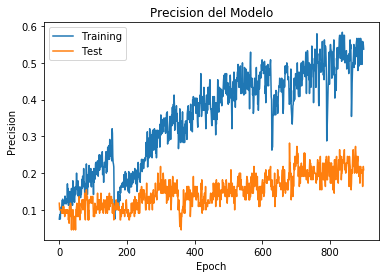

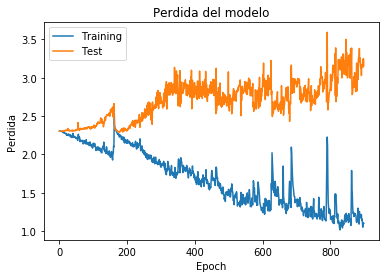

In [ ]:
plot_and_saving(LSTM2_1iter9005,name='LSTM_2Layer1D_13mfcc_Delta5iter900')

In [ ]:
LSTM2_1iter9008=LSTM_with_2layers_1D('LSTM_2Layer1D_13mfcc_Delta8iter900',dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 11s 47ms/step - loss: 2.3013 - acc: 0.1125 - val_loss: 2.3023 - val_acc: 0.0818
Epoch 2/400
240/240 [==============================] - 9s 36ms/step - loss: 2.2981 - acc: 0.0917 - val_loss: 2.3025 - val_acc: 0.0818
Epoch 3/400
240/240 [==============================] - 9s 36ms/step - loss: 2.3012 - acc: 0.0500 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 4/400
240/240 [==============================] - 8s 34ms/step - loss: 2.3017 - acc: 0.1458 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 9s 37ms/step - loss: 2.3017 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 6/400
240/240 [==============================] - 9s 37ms/step - loss: 2.3015 - acc: 0.0958 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/400
240/240 [==============================] - 9s 37ms/step - loss: 2.3007 - acc: 0.1167 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 8/400
240

240/240 [==============================] - 9s 37ms/step - loss: 2.2702 - acc: 0.1250 - val_loss: 2.3008 - val_acc: 0.1091
Epoch 62/400
240/240 [==============================] - 9s 39ms/step - loss: 2.2691 - acc: 0.1167 - val_loss: 2.3028 - val_acc: 0.1364
Epoch 63/400
240/240 [==============================] - 10s 41ms/step - loss: 2.2683 - acc: 0.0958 - val_loss: 2.3015 - val_acc: 0.1000
Epoch 64/400
240/240 [==============================] - 9s 37ms/step - loss: 2.2765 - acc: 0.1125 - val_loss: 2.3009 - val_acc: 0.1091
Epoch 65/400
240/240 [==============================] - 9s 37ms/step - loss: 2.2912 - acc: 0.1042 - val_loss: 2.2997 - val_acc: 0.1091
Epoch 66/400
240/240 [==============================] - 9s 38ms/step - loss: 2.2689 - acc: 0.1167 - val_loss: 2.2983 - val_acc: 0.1182
Epoch 67/400
240/240 [==============================] - 9s 38ms/step - loss: 2.2688 - acc: 0.1208 - val_loss: 2.2965 - val_acc: 0.1182
Epoch 68/400
240/240 [==============================] - 10s 41ms/st

In [ ]:
plot_and_saving(LSTM2_1iter9008,name='LSTM_2Layer1D_13mfcc_Delta8iter900')

In [ ]:
LSTM2_1iter2500=LSTM_with_2layers_1D('LSTM_2Layer1D_13mfcc_Delta5iter2500',dropout=0.5,n_epochs=1500)

In [ ]:
plot_and_saving(LSTM2_1iter2500,name='LSTM_2Layer1D_13mfcc_Delta5iter2500')

# Load Model 

In [35]:
import tensorflow as tf
from keras.utils import plot_model

Using TensorFlow backend.


In [37]:
def load_model(dir):
    m=tf.keras.models.load_model(dir)
    return m

# Recording audios and predict them

In [1]:
import sounddevice as sd
import ipywidgets as widgets
from IPython.display import display

In [3]:
button1 = widgets.Button(description="Record",)
button2 = widgets.Button(description='Test')
display(button)

def on_button_clicked(b):
    print("Button clicked.")

button1.on_click(on_button_clicked)
button2.on_click(on_button_clicked)


Button(description='Record', style=ButtonStyle())

In [ ]:
import pyaudio
import wave
 
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 48000#44100
CHUNK = 1024
RECORD_SECONDS = 2
WAVE_OUTPUT_FILENAME = "file.wav"
 
audio = pyaudio.PyAudio()
 
# start Recording
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
print ("recording...")
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print ("finished recording")
 
 
# stop Recording
stream.stop_stream()
stream.close()
audio.terminate()
 
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()

recording...


In [178]:
wave

<module 'wave' from '/home/visoc/anaconda3/envs/tf/lib/python3.6/wave.py'>

In [24]:
import librosa
wave, sr = librosa.load('file.wav', mono=True)
features= librosa.feature.mfcc(wave, sr,n_mfcc=13)

In [25]:
features
features=np.pad(features,((0,0),(0,110-len(features[0]))),mode='constant', constant_values=0)

In [36]:
features

array([[-3.62586372e+02, -3.28728780e+02, -3.36303349e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.21508306e+02,  9.78850590e+01,  9.77206386e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.02863909e+01,  2.09681557e+01,  1.58464190e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 5.30152744e+00,  4.83612102e+00,  5.33478991e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.52615483e+01,  1.27033446e+01,  9.75717578e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.13650198e-02, -5.84241393e+00, -5.46511897e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [27]:
delta=librosa.feature.delta(features)

/home/visoc/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [35]:
delta

array([[-7.57198727, -7.57198727, -7.57198727, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.22601343,  2.22601343,  2.22601343, ...,  0.        ,
         0.        ,  0.        ],
       [-0.90938914, -0.90938914, -0.90938914, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.4064893 , -0.4064893 , -0.4064893 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.10098799, -1.10098799, -1.10098799, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4734489 ,  0.4734489 ,  0.4734489 , ...,  0.        ,
         0.        ,  0.        ]])

In [37]:
np.concatenate((features,delta),axis=0)

array([[-362.58637206, -328.72877959, -336.30334884, ...,    0.        ,
           0.        ,    0.        ],
       [ 121.50830616,   97.88505903,   97.72063858, ...,    0.        ,
           0.        ,    0.        ],
       [  20.28639086,   20.96815566,   15.84641898, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [  -0.4064893 ,   -0.4064893 ,   -0.4064893 , ...,    0.        ,
           0.        ,    0.        ],
       [  -1.10098799,   -1.10098799,   -1.10098799, ...,    0.        ,
           0.        ,    0.        ],
       [   0.4734489 ,    0.4734489 ,    0.4734489 , ...,    0.        ,
           0.        ,    0.        ]])

In [187]:
#features = sklearn.preprocessing.scale(features, axis=1)
f=np.matrix.transpose(np.array([features]),[0,2,1])

In [188]:
label=model.predict_classes(f)

<bound method Sequential.get_config of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f4076c35128>>


In [189]:
decode(np.eye(10)[label])

array([['cuatro']], dtype='<U6')

In [35]:
label=class_to_integer_encoded(label[0]-1)

In [36]:
label

array([[6]])

In [37]:
label_encoder.inverse_transform(label)

array(['seis'], dtype='<U6')